**[MLE-01]** モジュールをインポートします。

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import multivariate_normal, permutation
import pandas as pd
# 「pandas」がライブラリに入っていない場合、「pip install pandas」にて組み込んでおくこと
from pandas import DataFrame, Series

**[MLE-02]** トレーニングセットのデータを用意します。

In [2]:
np.random.seed(20160512)

n0, mu0, variance0 = 20, [10, 11], 20
data0 = multivariate_normal(mu0, np.eye(2)*variance0 ,n0)
df0 = DataFrame(data0, columns=['x1','x2'])
df0['t'] = 0

n1, mu1, variance1 = 15, [18, 20], 22
data1 = multivariate_normal(mu1, np.eye(2)*variance1 ,n1)
df1 = DataFrame(data1, columns=['x1','x2'])
df1['t'] = 1

df = pd.concat([df0, df1], ignore_index=True)
train_set = df.reindex(permutation(df.index)).reset_index(drop=True)

**[MLE-03]** トレーニングセットのデータの内容を確認します。

In [3]:
train_set

,x1,x2,t
0,20.729880,18.209359,1
1,16.503919,14.685085,0
2,5.508661,17.426775,0
3,9.167047,9.178837,0
4,8.640423,9.561952,0
5,10.500988,17.002584,0
6,16.484766,22.232997,1
7,6.979059,8.180596,0
8,11.701339,0.996734,0
9,21.367990,18.712309,1


**[MLE-04]** (x1, x2) と t を別々に集めたものをNumPyのarrayオブジェクトとして取り出しておきます。

In [4]:
### 元のソースコード
#train_x = train_set[['x1','x2']].as_matrix()
#train_t = train_set['t'].as_matrix().reshape([len(train_set), 1])
### 上記はPython3.6でアラートとなるので、下記に修正
train_x = train_set[['x1','x2']].values
train_t = train_set['t'].values.reshape([len(train_set), 1])

**[MLE-05]** トレーニングセットのデータについて、t=1 である確率を求める計算式 p を用意します。

In [5]:
x = tf.placeholder(tf.float32, [None, 2])
w = tf.Variable(tf.zeros([2, 1]))
w0 = tf.Variable(tf.zeros([1]))
f = tf.matmul(x, w) + w0
p = tf.sigmoid(f)

**[MLE-06]** 誤差関数 loss とトレーニングアルゴリズム train_step を定義します。

In [6]:
t = tf.placeholder(tf.float32, [None, 1])
loss = -tf.reduce_sum(t*tf.log(p) + (1-t)*tf.log(1-p))
train_step = tf.train.AdamOptimizer().minimize(loss)

**[MLE-07]** 正解率 accuracy を定義します。

In [7]:
correct_prediction = tf.equal(tf.sign(p-0.5), tf.sign(t-0.5))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

**[MLE-08]** セッションを用意して、Variableを初期化します。

In [8]:
### >>> with GPU 80%
#gpuConfig = tf.ConfigProto(
#    gpu_options = tf.GPUOptions(
#        per_process_gpu_memory_fraction = 0.8),
#    device_count = {'GPU':0})
#sess = tf.Session(config = gpuConfig)
### <<<
#
### >>> with CPU only
sess = tf.Session()
### <<<
sess.run(tf.global_variables_initializer())
### 下記はPython3.6ではエラーとなるので、上記に変更した。
#sess.run(tf.initialize_all_variables())

**[MLE-09]** 勾配降下法によるパラメーターの最適化を20000回繰り返します。

In [9]:
i = 0
for _ in range(20000):
    i += 1
    sess.run(train_step, feed_dict={x:train_x, t:train_t})
    if i % 2000 == 0:
        loss_val, acc_val = sess.run(
            [loss, accuracy], feed_dict={x:train_x, t:train_t})
        print ('Step: %d, Loss: %f, Accuracy: %f'
               % (i, loss_val, acc_val))

Step: 2000, Loss: 15.165894, Accuracy: 0.885714
Step: 4000, Loss: 10.772635, Accuracy: 0.914286
Step: 6000, Loss: 8.197757, Accuracy: 0.971429
Step: 8000, Loss: 6.576121, Accuracy: 0.971429
Step: 10000, Loss: 5.511970, Accuracy: 0.942857
Step: 12000, Loss: 4.797994, Accuracy: 0.942857
Step: 14000, Loss: 4.314169, Accuracy: 0.942857
Step: 16000, Loss: 3.986260, Accuracy: 0.942857
Step: 18000, Loss: 3.766509, Accuracy: 0.942857
Step: 20000, Loss: 3.623066, Accuracy: 0.942857


**[MLE-10]** この時点のパラメーターの値を取り出します。

In [10]:
w0_val, w_val = sess.run([w0, w])
w0_val, w1_val, w2_val = w0_val[0], w_val[0][0], w_val[1][0]
### Python3.6対応版
print (w0_val, w1_val, w2_val)
### Python2.7用のオリジナルコード
#print w0_val, w1_val, w2_val

-15.630349 0.5602962 0.4925927


**[MLE-11]** 取り出したパラメーターの値を用いて、結果をグラフに表示します。

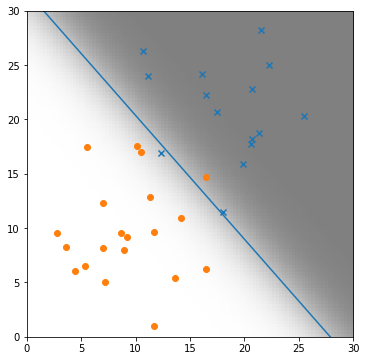

In [11]:
train_set0 = train_set[train_set['t']==0]
train_set1 = train_set[train_set['t']==1]

fig = plt.figure(figsize=(6,6))
subplot = fig.add_subplot(1,1,1)
subplot.set_ylim([0,30])
subplot.set_xlim([0,30])
subplot.scatter(train_set1.x1, train_set1.x2, marker='x')
subplot.scatter(train_set0.x1, train_set0.x2, marker='o')

linex = np.linspace(0,30,10)
liney = - (w1_val*linex/w2_val + w0_val/w2_val)
subplot.plot(linex, liney)

field = [[(1 / (1 + np.exp(-(w0_val + w1_val*x1 + w2_val*x2))))
          for x1 in np.linspace(0,30,100)]
         for x2 in np.linspace(0,30,100)]
subplot.imshow(field, origin='lower', extent=(0,30,0,30),
               cmap=plt.cm.gray_r, alpha=0.5)